# Lane Detection Project

# Team

* Omar Khaled Mokhtar Mohamed      1805974
* Omar Moataz Ebrahem Abu El Nour  1805659
* Omar El Hussein Ali Mohamed      1806424


# Arguments
## Taken from the bash/command line as arguments in python

In [ ]:
#Image=
#Video=
DEBUG=True   #true or false

# Imports

In [ ]:
import matplotlib.pyplot as plt
import cv2 
import numpy as np
import glob
import pickle
import os
from moviepy.editor import VideoFileClip
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
%matplotlib inline


# Camera Calibration

In [ ]:
def calibrate():
    """
    This function is used to calibrate camera from images of chessboard 
    captured from a camera for which camera matrix and distortion 
    coefficients are to be calculated 
    """
    # Create object points (0 0 0) ... (8 5 0)
    objp = np.zeros((9*6, 3), np.float32) 
    
    # assign grid points to x and y keeping z as zero
    objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

    # Stores all object points & img points from all images
    objpoints = []
    imgpoints = []

    
    images = glob.glob(r'camera_cal/calibration*.jpg')

    for indx, fname in enumerate(images):
        
        img = cv2.imread(fname)
        
       
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Find inner corners of chess baord
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    img_size = (img.shape[1], img.shape[0])

    # Calibrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

    # Save camera matrix and distortion coefficient to pickle file
    
    calibration_param = {}
    calibration_param['mtx'] = mtx
    calibration_param['dist'] = dist
    pickle.dump( calibration_param, open(r'calibration_pickle.pickle', 'wb') )

In [ ]:
def undistort_img(img, cal_dir = r'calibration_pickle.pickle'):
    
    
    # Read saved file
    with open(cal_dir, mode = 'rb') as f:
        file = pickle.load(f)
        
    mtx = file['mtx'] # camera matrix
    dist = file['dist'] # Distortion coefficients
    
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undistorted_img

In [ ]:
calibrate()


# Image Thresholding

In [ ]:
def img_threshold(img, s_thresh=(90, 255), sx_thresh=(25, 255)): 
    """
    Given input image 'img' this function first undistorts it and then applies thresholding on 
    the basis if x gradient values(computed using sobel operator) and saturation channel from HSL color space.
    """
   
    undistorted_img = undistort_img(img)
    
    gray_img =cv2.cvtColor( undistorted_img, cv2.COLOR_BGR2GRAY)
    gray_img=cv2.GaussianBlur(gray_img,(5,5),0)
   
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    #h_channel = hls[:, :, 0] # Hue channel
    s_channel = hls[:, :, 2] # Satuaration channel
    
    # Using sobel operator in x direction
    sobelx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0)
    
    # Sobel gives -ve derivative when transitoin is from light pixels to dark pixels
    # so taking absolute values which just indicates strength of edge
    abs_sobelx = np.absolute(sobelx)
    
    
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    white_binary = np.zeros_like(gray_img)
    white_binary[(gray_img > 150) & (gray_img <= 255)] = 1
    binary_1 = cv2.bitwise_and(sxbinary, white_binary)
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    
    combined_binary = np.zeros_like(sxbinary)
    
    
    combined_binary[((s_binary== 1) | (binary_1== 1))] = 1

    
    return combined_binary, undistorted_img


# Wrapping Image

In [ ]:


def perspective_transform(img):
    
    src = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    dst = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def inv_perspective_transform(img):
    
    dst = np.float32([[200, 720], [1100, 720], [595, 450], [685, 450]])
    src = np.float32([[300, 720], [980, 720], [300, 0], [980, 0]])
    
    img_size = (img.shape[1],img.shape[0])


    M = cv2.getPerspectiveTransform(src, dst)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    
    return warped

def get_hist(img):
    hist = np.sum(img[img.shape[0]//2:,:], axis=0)
    return hist

Text(0.5, 1.0, 'Warped thresholded image')

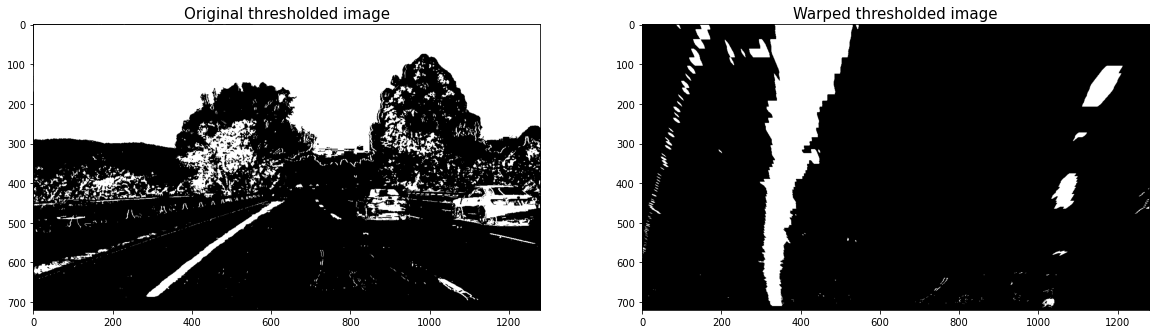

In [ ]:
img = cv2.imread('test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
threshold_img, undistorted_img = img_threshold(img)
warped_img = perspective_transform(threshold_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(threshold_img,cmap='gray')
ax1.set_title('Original thresholded image', fontsize = 15)

ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped thresholded image', fontsize = 15)

1280


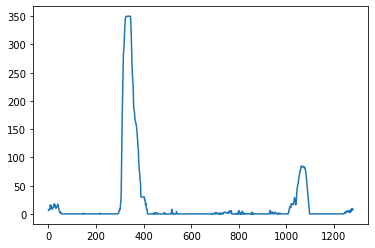

In [ ]:

newwarp = inv_perspective_transform(warped_img)
hist=get_hist(warped_img)
plt.plot(hist)
print(hist.shape[0])

# Pixel detection using sliding window

In [ ]:
def find_lane_pixels(image):
    hist=get_hist(image)
    out_img = np.dstack((image, image, image))
    midpoint = np.int(hist.shape[0]//2)
    leftx_base = np.argmax(hist[:midpoint])
    rightx_base = np.argmax(hist[midpoint:]) + midpoint
    nwindows = 9
    
    # Set the width of the windows +/- margin
    margin = 100
    
    # Set minimum number of pixels found to recenter window
    minpix = 200
    window_height = np.int(image.shape[0]//nwindows)
    
    left_lane= []
    right_lane = []
    leftx_current = leftx_base
    rightx_current = rightx_base
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
   
    nonzerox = np.array(nonzero[1])
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = image.shape[0] - (window+1)*window_height
        win_y_high = image.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low   = leftx_current - margin
        win_xleft_high  = leftx_current + margin
        win_xright_low  = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 4) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 4) 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
       
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane.append(good_left_inds)
        right_lane.append(good_right_inds)
        
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:   
             rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    try:
        left_lane = np.concatenate(left_lane)
        
        right_lane = np.concatenate(right_lane)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
  
    leftx = nonzerox[left_lane]
    lefty = nonzeroy[left_lane] 
    rightx = nonzerox[right_lane]
    righty = nonzeroy[right_lane]
    
    return leftx, lefty, rightx, righty, out_img


In [ ]:
def fit_polynomial(warped_img,undistorted_img,image):
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_img)
     
    
    # draw polonomials
    
    left_fit = np.polyfit(lefty, leftx, 2)
    
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, undistorted_img.shape[0]-1, undistorted_img.shape[0])
   
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    

    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_([ pts_right]),False,(0,255,255), thickness=20,)
    cv2.polylines(color_warp, np.int_([ pts_left]),False,(0,255,255), thickness=20,)
    newwarp = inv_perspective_transform(color_warp)
    
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
   # if (image) :   
    #    f, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
     #   ax1.imshow( out_img )
      #  ax1.set_title('Sliding Windows', fontsize = 15)

       # ax2.imshow(color_warp)
        #ax2.set_title('Warped detected image', fontsize = 15)
    
    
    
    
    return result, left_fitx, right_fitx,left_fit,right_fit, ploty,out_img ,color_warp

# Center Offset

In [ ]:
def meausre_center_offset(left_fit_cr,right_fit_cr,img_shape):
   
    # meters per pixel in xdimension
    xm_per_pix = 5/1200 
    
    car_pos = img_shape[1]/2
    
    left_lane_bottom_x = left_fit_cr[0]*img_shape[0]**2 + left_fit_cr[1]*img_shape[0] + left_fit_cr[2]
    right_lane_bottom_x = right_fit_cr[0]*img_shape[0]**2 + right_fit_cr[1]*img_shape[0] + right_fit_cr[2]
    lane_center_position = ((right_lane_bottom_x - left_lane_bottom_x) / 2) + left_lane_bottom_x
    car_center_offset = np.abs(car_pos - lane_center_position) * xm_per_pix
    
    return  car_center_offset
    

# Lane Curvature

In [ ]:
def measure_curvature(left_fitx, right_fitx, ploty):
    # meters per pixel in y dimension
    ym_per_pix = 30/720  
    xm_per_pix = 5/1200 
    #left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    left_fit_cr=left_fitx
    right_fit_cr=right_fitx
    #max value in y
    y_eval =np.max(ploty)
        
    #Formula for curavature R = (1 + (2Ay + B)^2)^(3/2) / (|2A|)
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 +( (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2))**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + ((2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2))**1.5) / np.absolute(2*right_fit_cr[0])
    
        
    return np.mean([left_curverad, right_curverad])

# Car Detection

In [ ]:
weights_path="yolov3.weights"
config_path="yolov3.cfg"
labels_path="coco.names"
net=cv2.dnn.readNetFromDarknet(config_path,weights_path)    
name=net.getLayerNames()
layers_name=[name[i[0]-1]for i in net.getUnconnectedOutLayers()]
labels=open(labels_path).read().strip().split("\n")

NameError: ignored

In [ ]:
def car_detection(img):
    
    (H,W)=img.shape[:2]
    
    
    blob=cv2.dnn.blobFromImage(img,1/255.0,(416,416),crop=False,swapRB=False)
    net.setInput(blob)
    
    layers_output=net.forward(layers_name)
    
    boxes=[]
    confidences=[]
    ClassIds=[]
    
   
    for output in layers_output:
    
        for detection in output:
            scores=detection[5:]
            classID=np.argmax(scores)
            confidence=scores[classID]
        
            if (confidence >0.85):
                box=detection[:4]*np.array([W,H,W,H])
                bx,by,bw,bh=box.astype("int")
            
                x= int(bx-(bw/2))
                y= int(by-(bh/2))
            
                boxes.append([x,y,int(bw),int(bh)])
                confidences.append(float(confidence))
                ClassIds.append(classID)
   
    idxs=cv2.dnn.NMSBoxes(boxes,confidences,0.8,0.8)
                
    if len(idxs) > 0:
    
    
                for i in idxs.flatten():
                    (x,y)=[boxes[i][0],boxes[i][1]]
                    (w,h)=[boxes[i][2],boxes[i][3]]
                    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
                    cv2.putText(img,"{}:{:.3f}".format(labels[ClassIds[i]],confidences[i]),(x,y-5),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,255,255),2)
    
    return img

# Pipeline

In [ ]:
def lane_Detector(frame,DEBUG=False):
    threshold_img,undistorted_img=img_threshold(frame)
    threshold_img=threshold_img*255

    warped_img = perspective_transform(threshold_img)
    result, left_fitx, right_fitx,left_fit,right_fit, ploty,out_img ,color_warp= fit_polynomial(warped_img, undistorted_img,False)
    car_center_offset= meausre_center_offset(left_fit,right_fit,frame.shape)
    Lane_curvture= measure_curvature(left_fit, right_fit, ploty)
    result=car_detection(result)
    cv2.putText(result, 'Lane Curvature: {:.0f} m'.format(Lane_curvture), 
                (50, 50), fontScale=1,fontFace=cv2.FONT_HERSHEY_SIMPLEX, color=(0,0,0), thickness =2)
    cv2.putText(result, 'Vehicle offset: {:.4f} m'.format(car_center_offset), (50, 100),  fontScale=1, fontFace=cv2.FONT_HERSHEY_SIMPLEX,color=(0,0,0), thickness =2)
    
    if (DEBUG):
           result= DEBUG_IMG(frame,result,warped_img,threshold_img,out_img ,color_warp)
    #cv2.imshow('Frame',threshold_img)
    return result

# Images

In [ ]:
def DEBUG_IMG(original_img,result_img,stage_1,stage_2,stage_3,stage_4):
    #convert grey scale to colored img
    if(len(stage_1.shape)<3):
        stage_1=cv2.cvtColor(stage_1,cv2.COLOR_GRAY2BGR)
    if(len(stage_2.shape)<3):
        stage_2=cv2.cvtColor(stage_2,cv2.COLOR_GRAY2BGR)
    if(len(stage_3.shape)<3):
        stage_3=cv2.cvtColor(stage_3,cv2.COLOR_GRAY2BGR)
    if(len(stage_4.shape)<3):
        stage_4=cv2.cvtColor(stage_4,cv2.COLOR_GRAY2BGR)
    width = int(original_img.shape[1] * 0.5)
    height = int(original_img.shape[0] * 0.5)
    dim=(width,height)
    top_hstack = np.hstack((result_img,original_img))
    resized_s1=cv2.resize(stage_1, dim, interpolation = cv2.INTER_AREA)
    resized_s2=cv2.resize(stage_2, dim, interpolation = cv2.INTER_AREA)
    resized_s3=cv2.resize(stage_3, dim, interpolation = cv2.INTER_AREA)
    resized_s4=cv2.resize(stage_4, dim, interpolation = cv2.INTER_AREA)
    bottom_hstack=np.hstack((resized_s1,resized_s2,resized_s3,resized_s4))
    out= np.vstack((top_hstack,bottom_hstack))
    width = int(out.shape[1] * 0.5)
    height = int(out.shape[0] * 0.5)
    dim=(width,height)
    out_resized=cv2.resize(out, dim, interpolation = cv2.INTER_AREA)
    return out_resized

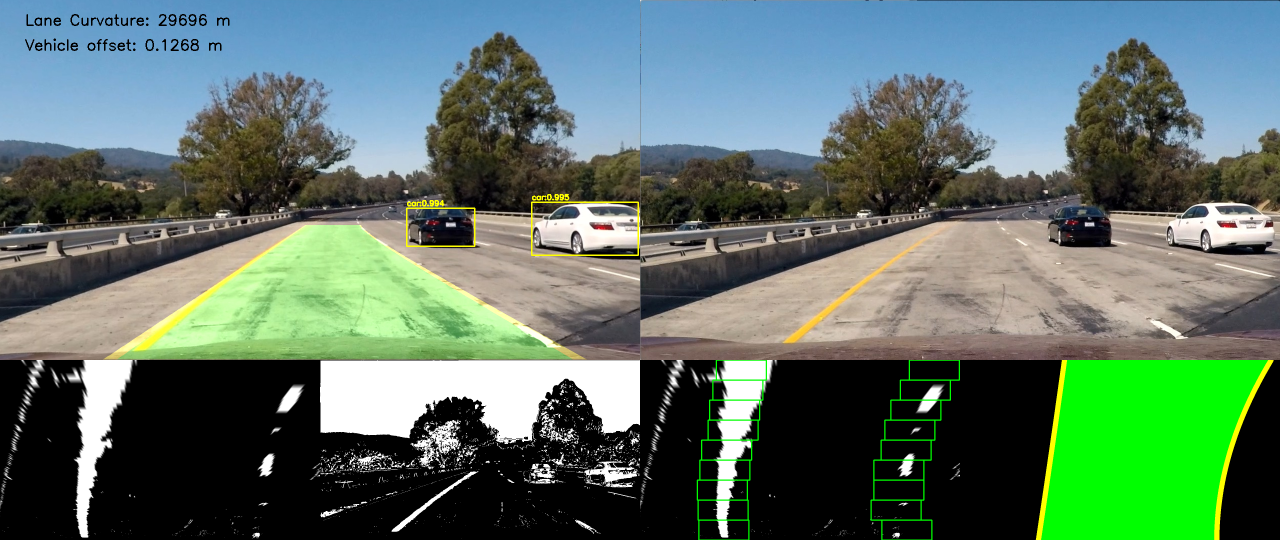

In [ ]:
img = cv2.imread(r'test1.jpg')
result=lane_Detector(img,DEBUG)
cv2_imshow(result)
cv2.waitKey(0)
cv2.destroyAllWindows()



# Video

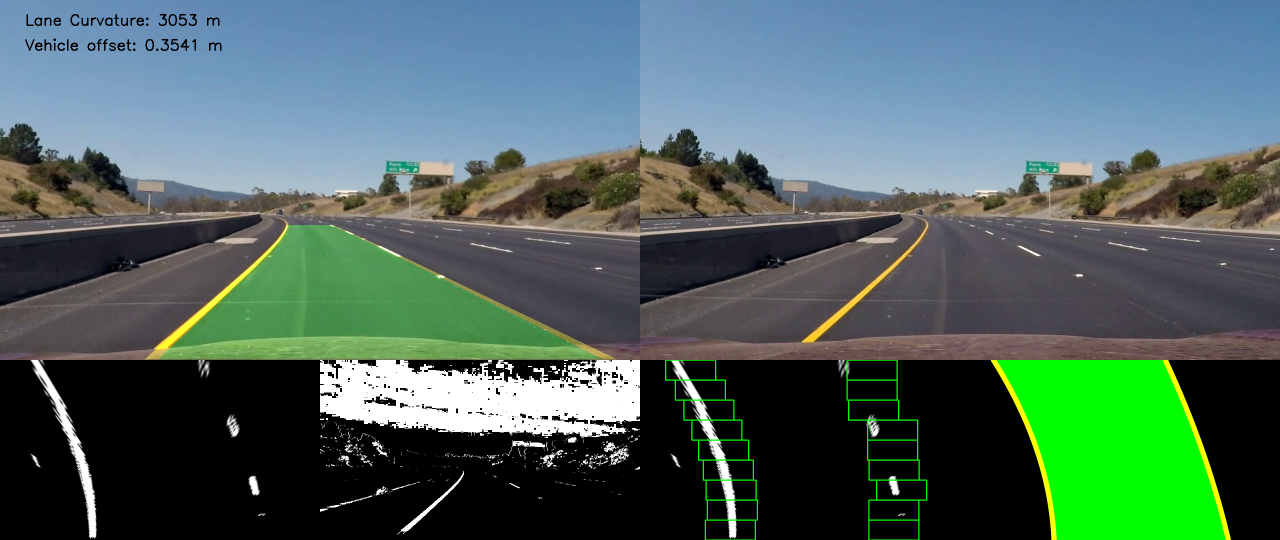

KeyboardInterrupt: ignored

In [ ]:
cap=cv2.VideoCapture(r'project_video.mp4')
while (cap.isOpened()):
    ret,frame =cap.read()
    result=lane_Detector(frame,DEBUG)
    clear_output(wait=True)
    cv2_imshow(result)
   

cap.release()
cv2.destroyAllWindows() 

In [ ]:
"""video_output = (r'project_video_output.mp4')
clip1 = VideoFileClip(r'project_video.mp4')
output_clip = clip1.fl_image(lane_Detector)
%time output_clip.write_videofile(video_output, audio=False)"""